# CAP Theorem Applied

* Peter Silva, 2023



### CAP Theorem 
 * Originally proposed by Eric A. Brewer in 2000. 
 * Proved in 2002 by Gilbert & Lynch.
 * Definitions from Gilbert & Lynch
 
### Definitions
* Consistency -  _any read operation that begins after a write operation completes must return that value, or the result of a later write operation_ 
* Availability - _every request received by a non-failing node in the system must result in a response_ 
* Partition (Tolerance) - _the network will be allowed to lose arbitrarily many messages sent from one node to another_ 

## Cap Theorem

* An ideal distributed system will feature all Consistency, Availability, and Partition Tolerance. 

* In reality, the best one can do is 2 out of three. 

## Proof

* walk through: Gilbert & Lynch (Thanks to MWhittaker): https://mwhittaker.github.io/blog/an_illustrated_proof_of_the_cap_theorem/ ?

* Real usage of CAP theoream involves looking at what is pragmatic in real-life cases.

# Storage/State

* What is a File System? -- an ordered list of writes (with a path)

* What is a SQL Database? -- an ordered list of writes (with indices)

* What is a File? - an ordered list of bytes, with an id (path.)

* What is an Object (in object storage context) -- an ordered list of bytes, with an id (opaque hash)

## They Are All Units of Synchronization
* Traditional databases and file systems are just really large files.  
* files and objects are the same thing
* They are units of synchronization/state.
* Consistency == order == synchronization == global state.
* When Distributed...
  * User expectation is coherence/consistency
  * Coherence is the same thing as shared state.
* Amdahl's Law tells us that scaling global state is really, really hard.


In [96]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow, FancyArrowPatch

def three_circles(ax, x, y, box_bg, arrow1):
    patches = [
        Circle( (x,y), 0.3, fc=box_bg),
        Circle( (x+2,y), 0.3, fc=box_bg),
        Circle( (x+1, y-1), 0.3, fc=box_bg),
        FancyArrow( x+0.4, y, 1.2, 0, fc=arrow1, width=0.05, head_width=0.05, head_length=0 ),
        FancyArrow( x+0.25, y-0.3, 0.4, -0.4, fc=arrow1, width=0.05, head_width=0.05, head_length=0),
        FancyArrow( x+1.7, y-0.3, -0.4, -0.4, fc=arrow1, width=0.05, head_width=0.05, head_length=0),
    ]
    
    for p in patches:
        ax.add_patch(p)
    plt.text(x-0.15,y+0.4, 'G1', fontsize=20)
    plt.text(x+1.85,y+0.4, 'G2', fontsize=20)
    plt.text(x+0.70,y-1.6, 'Client', fontsize=20)
    
def create_base(box_bg = '#CCCCCC',
                arrow1 = '#88CCFF',
                arrow2 = '#88FF88',
                supervised=True):
    
    fig = plt.figure(figsize=(8, 4.2), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),
                 xticks=[], yticks=[], frameon=False)
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 6)

    x=3
    y=3
    three_circles(ax, x,y,box_bg,arrow1)



In [95]:
# Proof of IOPS ceiling
SAN_iops=100000
time_for_1_iop=1/SAN_iops
distance=600
c=300000
tprop=distance/c
max_iops=1/(2*(time_for_1_iop+tprop))

print( f"Assuming a file system can do {SAN_iops} IOPS")
print( f"distance between data centres={distance}, speed of light={c} km/s,  time to travel (1way)={tprop} sec. " )


Assuming a file system can do 100000 IOPS
distance between data centres=600, speed of light=300000 km/s,  time to travel (1way)=0.002 sec. 


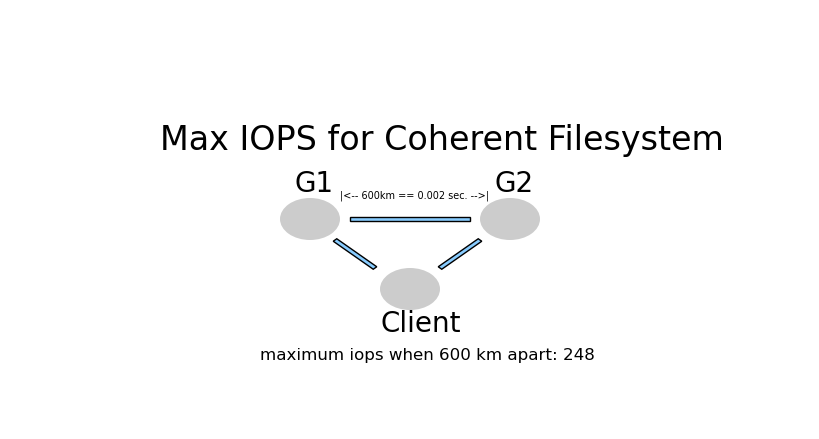

In [92]:
create_base()
plt.text(1.5, 4, 'Max IOPS for Coherent Filesystem',fontsize=24)
plt.text(3.3, 3.3, '|<-- 600km == 0.002 sec. -->|', fontsize=7)
plt.text(2.5, 1.0, f"maximum iops when {distance} km apart: {int(max_iops)}", fontsize=12)

plt.show()

## Pick any 2, Which two?

* CA: Consistency and Availability
* AP: Availabilty and Partition Tolerance.
* CP: Consistency and Partition Tolerance

### Choosing CA:
* At best, you need a quorum system.
* quorum means obtaining a consensus among the existing nodes about the current state.
* usually means voting for primaries (at best, sharded masters) and triggering a pause to vote for a new primary whenever it goes down.
* The system as a whole, cannot respond to queries while voting is in progress, and so is unavailable.
* but at least it is up after the vote is done, in spite of the formerly primary node dying.


### Quorum and Voting:
* Multiple Algorithms:
  * Paxos: "Paxos is exceptionally difficult to understand"
  * "few people were comfortable with Paxos even among seasoned researchers"

* papers like "In Search of an Understandable Consensus Algorithm (Extended Version)" resulted in RAFT

* Things you want:
   * quickly convergent?
   * a single leader elected?
   * low overhead once leader in place.
   * quick detection of loss of leader.
   * known behaviour when: flapping, partitioning, WAN.

* If it partitions, tradeoffs:
   * AP: both sides will elect new leaders and "fork" the file system (writing inconsistently thereafter.) OR:
   * CA: One side will know it has a minority of nodes and shutdown (losing a lot of nodes, but hoping the other side is still up.) OR:
   * CP: both sides refuse to write.  (no A for writing.)
   
 

### Choosing AP:

* incoming requests are routed to the nodes that remain up. They provide the data they have.
* you don't need a master. nodes receive updates, and tell the others, 
* changes propagate through the cluster... eventually consistent.
* no voting, no loss of availability.

### Voting Failure Modes


| Number of Masters |       < 1                  |         1                |      >1      |
|-------------------|----------------------------|--------------------------|--------------|
|  All Talk         |  Down wait                 |        Up OK             |   Bickering  |
|  Partitioned      |  Unstable LR               |     Unstable LR          |      LR      |

(LR... partitioned into left and right clusters.)


### Choosing CP:
  * as long as the backups can reach the primary, all can answer read requests.
  * when a write is received, the backup passes it to the primary.
  * when a backup loses access to the primary, for coherency, it must stop answering. It no longer knows.
  * A Manual intervention would be required to tell the backup that it is now the primary in order for availability to be restored, because there is no way to tell the difference between a primary failure and a network partition.


## Bringing Amdahl & CAP Together

* Amdahl's Law is about dealing with large numbers of processors sharing resources.
  
* CAP is about tradeoffs inherent using different methods of sharing resources.

## Almost-Coherent File System or DB Performance

* A bandaid on Traditional single node 
* a synchronized file system is going to have ordered operations, it is going to be a 1:1 connection with shared state.
* usually a "journal" to sync between sides.
* in the meantime, readers on the wrong side get the _wrong_ data.  
* sometimes you establish an upper bound (if you hit it, you hang so that it doesn't get too out of sync.)
* synchronization is a struggle against Amdahl's Law.
* will not scale.

## Universal Write Scaling

* obtain delegation for a subdomain, write locally.

  * write behind cache ... the write will get to the other side eventually, but G1 and G2 will be out of synch for a while. 

  * sharding (dividing domain so every node is writing locally.) 
  * route requests to appropriate shard.

* locks over smaller subsets --> more write parallelism.
* writes must be localized (no solution for scaled distributed writes.)



## Non-Shared Approaches.

* the only thing that does scale.
* transfer files or objects, rather than synchronizing file systems. maximally distributed synchronization.
  * explicit sharding.
* any number of transfers can occur in parallel.
* the underlying file systems are local stores.
  * are not the same, they just contain the same files, eventually.
  * are not synchronized at any point, they receive a sum of changes that add up to the same stored state.
* lag can occur, but can run an unlimited number of processes to do transfers, none limited by propagation delay. Transfers occur in parallel to the degree desired.
* Because the transfers are independent, no fundamental performance limit, beyond the perfomance of hardware on each end, and the pipe between.



## Examples of Non-Shared Approaches

### Object Stores

* An object is a self-contained item that can be distributed.
* Every object is equivalent to a db or a file system. 
* with many objects, state is distributed among subsets of nodes, not global.
* distribution of objects (with lag) is much easier to achieve than a coherent view.
* Different Object Stores lean in different directions in CAP.
* requires application adaptation, perhaps profound.


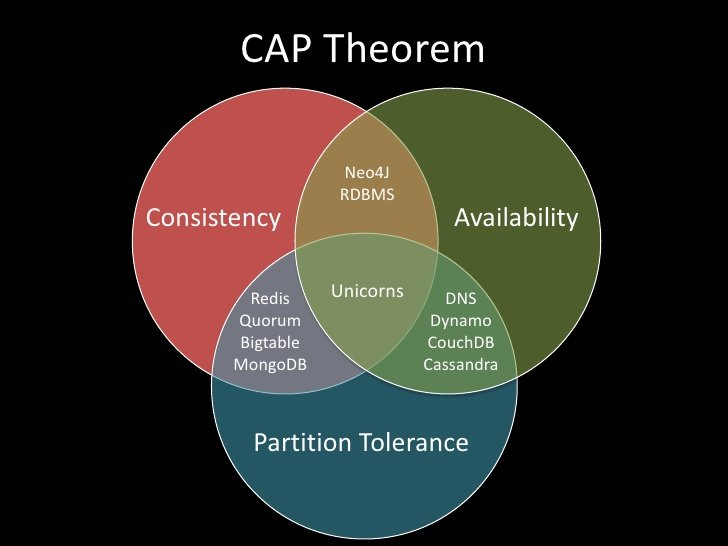

* Source: Fotis Nikolaidis from "Tromos : a software development kit for virtual storage
systems" (PhD thesis 2020/01/17)

## Cloud Solves This!

* cloud vendors talk about "availability zones" there is no HA or synch across availabilty zones, they talk about times like 15 minutes, to do periodic synching. Object syncing takes time (and money.)
* 2006, HP DC Consolidation project established 200 miles as the longest distance between Data Centres. So that would give them 500 IOPS or so on a synchronous store.
* Note, putting a file system or a db inside a single object store means no scaling. 
* Individual objects don't scale, using many objects does.

from: https://aws.amazon.com/rds/features/multi-az/

* *Failover time depends on length of replica lag*
* *Any data updates that occurred after the latest restorable time (typically within the last 5 minutes) will not be available*

From Google: https://cloud.google.com/compute/docs/disks#repds
* *Regional persistent disks have storage qualities that are similar to zonal persistent disks. However, regional persistent disks provide durable storage and replication of data between two zones in the same region.*
* *Zonal SSD PD multi-writer mode Throughput per GB (MB/s): 0.48*


the google performance numbers are within a zone (multi-DC but not too far apart.) not multi-zone.




### Sarracenia: File Systems Flying in Formation

* Another distributed approach
* transfers files between file systems without synchronizing.
* Every file is equivalent to an object, a db or a file system.
* no locking, architecturally unlimited scaling.
* generalized buffering and parallelism of transfer at scale.
* file systems at all nodes are totally independent, limited only by local hardware on each node.  
* transfers limited by bandwidth, not latency.
* works with legacy code un-changed, or new (agnostic.)
* In terms of CAP--> heavily AP.


# Thanks!


Sources:

* https://mwhittaker.github.io/blog/an_illustrated_proof_of_the_cap_theorem/ (An Illustrated Proof of the CAP Theorem, referring to Gilbert & Lynch's paper which is a dead link. )
* https://en.wikipedia.org/wiki/Fallacies_of_distributed_computing
* https://www.youtube.com/watch?v=eWMgsk7mpFc&ab_channel=IBMTechnology
* https://eax360.com/distributed-coordination-algorithms/ - Distributed Coordination Algorithms
* https://raft.github.io/raft.pdf In search of an Understandable Consensus Algorithm (Extended Version) Diego Ongaro and John Ousterhout.
* https://www.cs.ubc.ca/~bestchai/teaching/cs416_2020w2/lectures/lecture-mar23.pdf - fun practical talk about practical CAP.


In [94]:
# See distributed co-ordination algorithms for details of each one.

# How many messages are moving around to pick a master.

# number of nodes in the group of servers
G=10
# each 
quorum = {}
# single Server case (no cluster) - request and response, that's it.
quorum["SingleServer"] = 0

#Primary/Backup - each backup that gets a request asks the master.
quorum["Primary/Backup"]=( 1+(G-1/G
                             
                             ), 0 )

# used often in Blockchains... leaves open the idea of a QuorumSize
quorum["QuorumConsensus"]=0

# Paxos -- the grandaddy.... 
# has a broadcast, those don't work outside LAN so counting it as G-1 messages
# BroadcastPropose - G messages ... one node decides to have a vote,
#  the rest of the nodes respond with their votes.
#  The maximum value is then broadcast...
# BroadcastPromise - G messages...
# BroadcastAccept  - G
# BroadcastLearn   - G

quorum["Paxos"]=( 1+(G-1/G), 4*G )



quorum["Raft"]=( 1+G/2, 4*G )


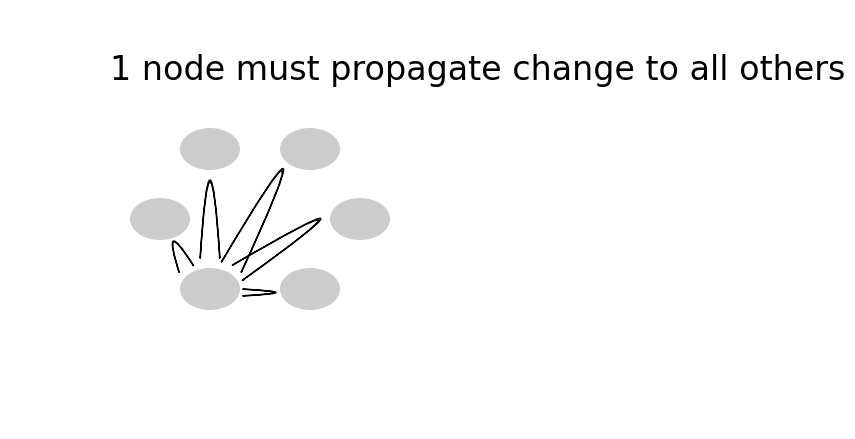

In [88]:
def cluster(box_bg = '#CCCCCC', arrow1 = '#88CCFF', arrow2 = '#88FF88'):
    fig = plt.figure(figsize=(8, 4.2), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),xticks=[], yticks=[], frameon=False)
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 6)
    x=2
    y=2
    patches = [
        Circle( (x,y), 0.3, fc=box_bg),
        Circle( (x+1,y), 0.3, fc=box_bg),
        Circle( (x+1.5,y+1), 0.3, fc=box_bg),
        Circle( (x-0.5,y+1), 0.3, fc=box_bg),
        Circle( (x,y+2), 0.3, fc=box_bg),
        Circle( (x+1,y+2), 0.3, fc=box_bg),
        FancyArrowPatch((x+0.1,y+0.35), (x+0.3,y+0.2), connectionstyle="arc3,rad=-10" ),
        FancyArrowPatch((x-0.1,y+0.4), (x+0.1,y+0.4), connectionstyle="arc3,rad=-8" ),
        FancyArrowPatch((x-0.3,y+0.2), (x-0.15,y+0.3), connectionstyle="arc3,rad=-4" ),
        FancyArrowPatch((x+0.2,y+0.32), (x+0.3,y+0.1), connectionstyle="arc3,rad=-11" ),
        FancyArrowPatch((x+0.3,y), (x+0.3,y-0.1), connectionstyle="arc3,rad=-10" )
    ]
    for p in patches:
        ax.add_patch(p)
    
        
cluster()
plt.text(1, 5, '1 node must propagate change to all others',fontsize=24)

plt.show() 
